<a href="https://colab.research.google.com/github/Shauryam22/AI-vs-Human-Text-Detection-Using-Graph-Neural-Network/blob/main/Copy_of_textgcn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import annotations
import math
import random
from collections import Counter, defaultdict
from itertools import combinations
import seaborn as sns

import numpy as np
import scipy.sparse as sp
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd

In [7]:
import kagglehub
path = kagglehub.dataset_download("shanegerami/ai-vs-human-text")
path

Using Colab cache for faster access to the 'ai-vs-human-text' dataset.


'/kaggle/input/ai-vs-human-text'

In [8]:
import os
print(os.listdir(path))
# to get the file name


['AI_Human.csv']


In [9]:
import pandas as pd
import csv

df = pd.read_csv('/kaggle/input/ai-vs-human-text/AI_Human.csv')




In [10]:
df['text'][0]  # seeing the data example

'Cars. Cars have been around since they became famous in the 1900s, when Henry Ford created and built the first ModelT. Cars have played a major role in our every day lives since then. But now, people are starting to question if limiting car usage would be a good thing. To me, limiting the use of cars might be a good thing to do.\n\nIn like matter of this, article, "In German Suburb, Life Goes On Without Cars," by Elizabeth Rosenthal states, how automobiles are the linchpin of suburbs, where middle class families from either Shanghai or Chicago tend to make their homes. Experts say how this is a huge impediment to current efforts to reduce greenhouse gas emissions from tailpipe. Passenger cars are responsible for 12 percent of greenhouse gas emissions in Europe...and up to 50 percent in some carintensive areas in the United States. Cars are the main reason for the greenhouse gas emissions because of a lot of people driving them around all the time getting where they need to go. Article

<Axes: xlabel='generated', ylabel='count'>

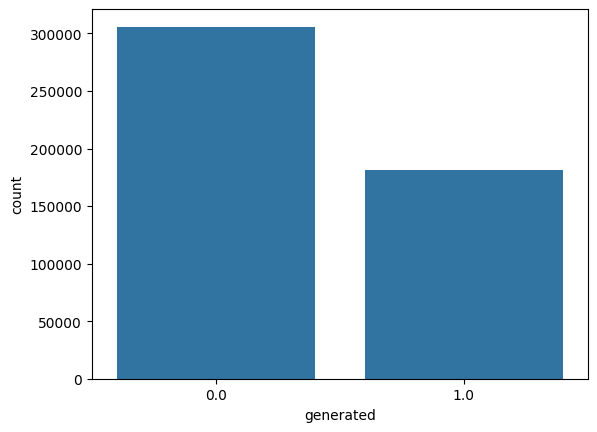

In [11]:
# EDA
labels = df['generated']
sns.countplot(x=df['generated'])

In [12]:
labels[487232]

np.float64(1.0)

In [13]:


def remove_tags(text):
    tags = ['\n', '\'']
    for tag in tags:
        text = text.replace(tag, '')

    return text


df['text'] = df['text'].apply(remove_tags)



In [14]:
df['text'][0]

'Cars. Cars have been around since they became famous in the 1900s, when Henry Ford created and built the first ModelT. Cars have played a major role in our every day lives since then. But now, people are starting to question if limiting car usage would be a good thing. To me, limiting the use of cars might be a good thing to do.In like matter of this, article, "In German Suburb, Life Goes On Without Cars," by Elizabeth Rosenthal states, how automobiles are the linchpin of suburbs, where middle class families from either Shanghai or Chicago tend to make their homes. Experts say how this is a huge impediment to current efforts to reduce greenhouse gas emissions from tailpipe. Passenger cars are responsible for 12 percent of greenhouse gas emissions in Europe...and up to 50 percent in some carintensive areas in the United States. Cars are the main reason for the greenhouse gas emissions because of a lot of people driving them around all the time getting where they need to go. Article, "P

In [15]:
df = df.sample(frac=1).reset_index()
df1 = df[:10000]



In [16]:
df1

index                                               text  generated
0     211004  Have you ever thought of being a Seagoing Cowb...        0.0
1     142112  Dear TEACHER_NAME,I agree 100% with you. U thu...        0.0
2     452411  The popularity OG competitive programming and ...        1.0
3     273864  I am going to be talking about how the use of ...        0.0
4      24003  I agree that it is better to have broad knowle...        1.0
...      ...                                                ...        ...
9995  150038  As an eighthgraMe student, I believe that the ...        1.0
9996  327565  [Your name][Your address][City, state ZIP code...        1.0
9997   27303  There has been much debate in recent years abo...        1.0
9998  268717   One activity that I find truly enjoyable are ...        1.0
9999  217812  In todays fast paced word, it is often said th...        1.0

[10000 rows x 3 columns]

In [17]:
TOY_DOCS = df1['text']
TOY_LABELS = df1['generated']
CLASS_NAMES = ['A','H']

<Axes: xlabel='generated', ylabel='count'>

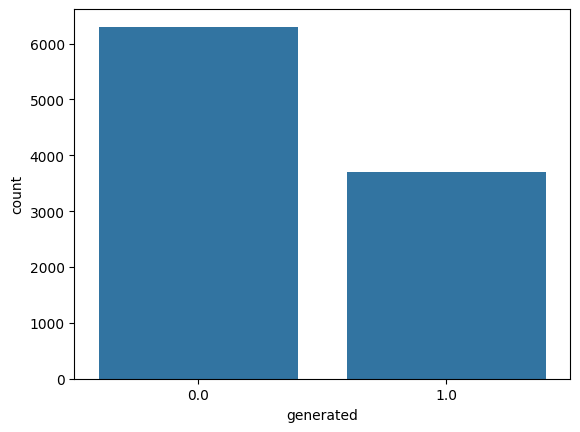

In [18]:
sns.countplot(x=TOY_LABELS)

In [19]:
TOY_DOCS

0       Have you ever thought of being a Seagoing Cowb...
1       Dear TEACHER_NAME,I agree 100% with you. U thu...
2       The popularity OG competitive programming and ...
3       I am going to be talking about how the use of ...
4       I agree that it is better to have broad knowle...
                              ...                        
9995    As an eighthgraMe student, I believe that the ...
9996    [Your name][Your address][City, state ZIP code...
9997    There has been much debate in recent years abo...
9998     One activity that I find truly enjoyable are ...
9999    In todays fast paced word, it is often said th...
Name: text, Length: 10000, dtype: object

In [20]:
# 2) Build vocabulary
# ------------------------------
MIN_WORD_FREQ = 15
TOKENIZE = lambda s: [t for t in s.lower().split()]    # all it does is splits the words into list and loweres the cases


word_counts = Counter()
for d in TOY_DOCS:
  #print(TOKENIZE(d))
  word_counts.update(TOKENIZE(d))

In [21]:
vocab = [w for w, c in word_counts.items() if c >= MIN_WORD_FREQ]


In [22]:
word2id = {w: i for i, w in enumerate(sorted(vocab))}


In [23]:
V = len(word2id) # number of word nodes
D = len(TOY_DOCS) # number of document nodes i.e no of sentences
N = V + D


In [24]:
N #total nodes

20764

In [25]:
print(f"Words: {V}, Docs: {D}, Total nodes: {N}")

Words: 10764, Docs: 10000, Total nodes: 20764


In [26]:
vec = TfidfVectorizer(vocabulary=word2id, tokenizer=TOKENIZE, lowercase=True, use_idf=True, norm=None)

In [27]:
vec

TfidfVectorizer(norm=None, tokenizer=<function <lambda> at 0x7f381ca78d60>,
                vocabulary={'!': 0, '"': 1, '".': 2, '"...': 3, '"a': 4,
                            '"according': 5, '"action': 6, '"after': 7,
                            '"alien': 8, '"aliens"': 9, '"all': 10, '"as': 11,
                            '"astronomers': 12, '"at': 13, '"b"': 14,
                            '"back': 15, '"because': 16, '"but': 17,
                            '"calculation"': 18, '"can': 19, '"car': 20,
                            '"car-free': 21, '"carefree': 22, '"carefree"': 23,
                            '"certificate': 24, '"cold': 25, '"congestion': 26,
                            '"day': 27, '"determine': 28, '"disaster': 29, ...})

In [28]:
X_dv = vec.fit_transform(TOY_DOCS)

/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [ ]:
#X_dv

In [29]:
WINDOW_SIZE = 4     #running window size

In [30]:
windows = []
for doc in TOY_DOCS:
  tokens = TOKENIZE(doc)
  if len(tokens) <= WINDOW_SIZE:
    windows.append(tokens)
  else:
    for i in range(len(tokens) - WINDOW_SIZE + 1):
      windows.append(tokens[i:i+WINDOW_SIZE])

In [31]:
word_window_freq = Counter() #marginal count
pair_window_freq = Counter() #joint count


for w in windows:
  unique_w = list(set([t for t in w if t in word2id]))  #if is needed since we filtered in wor2id by frequency of words, whereas w contains all of the words. we dont want all words we want ony those present in word2id
  #print(unique_w)
  for t in unique_w:
    word_window_freq[t] += 1   # counting how many times a word appear in each window.if a word appears again in another window then num of app of that word +1.
   # print( word_window_freq[t])
  for a, b in combinations(sorted(unique_w), 2):  #making all possible combination(pairs of 2 here) of words present in a unique word window.
    pair_window_freq[(a, b)] += 1   # p(i,j) joint prob/counts of pair existence.

#print(windows)
num_windows = len(windows)
#print(word_window_freq)   # doc freq (df)
#print(pair_window_freq)
#print(num_windows)



In [32]:
#word_window_freq['tf'] = word_window_freq['tf']/num_windows

In [33]:
rows = []
cols = []
data = []
# (a,b)---> words pair       c_ab-----> sum of count of their appearance in all windows
for (a, b), c_ab in pair_window_freq.items():
  p_ab = c_ab / num_windows
  p_a = word_window_freq[a] / num_windows
  p_b = word_window_freq[b] / num_windows
  pmi = math.log(p_ab / (p_a * p_b) + 1e-12)
  if pmi > 0:
    i = word2id[a]
    j = word2id[b]
  # undirected edge -> add both (i,j) and (j,i)
    rows.extend([i, j])
    cols.extend([j, i])
    data.extend([pmi, pmi])


In [34]:
#word_window_freq

In [35]:
Ww = sp.csr_matrix((data, (rows, cols)), shape=(V, V))
# Ww

In [36]:
# ------------------------------
# 5) Assemble the heterogeneous adjacency A (N x N)
# ------------------------------
# Blocks:
#   [ Ww   X_dv^T ]
#   [ X_dv   0    ]   (no direct doc–doc edges in vanilla TextGCN)

top_right = X_dv.T  # (V x D)
bottom_left = X_dv  # (D x V)

In [37]:
A = sp.bmat([[Ww,           top_right],
             [bottom_left,  None     ]], format='csr')


In [38]:
# Add self-loops
A = A + sp.eye(N, format='csr')

# print(A)

In [39]:
rowsum = np.array(A.sum(axis=1)).flatten()    # sum of nth row gives us the nth node total connections
# rowsum

In [40]:
d_inv_sqrt = np.power(rowsum, -0.5)
d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.0
D_inv_sqrt = sp.diags(d_inv_sqrt)
A_hat = D_inv_sqrt.dot(A).dot(D_inv_sqrt).tocsr() # to csr format
# print(A_hat) # normalised adjacency matrix

In [41]:
# Convert to torch sparse tensor
A_hat_coo = A_hat.tocoo()
#print(A_hat_coo.row)
indices = torch.from_numpy(np.vstack([A_hat_coo.row, A_hat_coo.col]).astype(np.int64))
#print(indices)
values = torch.from_numpy(A_hat_coo.data.astype(np.float32))
#print(values)
A_hat_t = torch.sparse_coo_tensor(indices, values, torch.Size(A_hat_coo.shape)).coalesce()   # since the og matrix is A_hat_coo , so its shape is og shape
# print(A_hat_t.indices())  # gives the (row,col) coord of all nonzero element, first row then column, ith row pair with ith col
# print(A_hat_t.values())  # that actual nnz values or we can say data


In [42]:
# 6) Labels and train/val/test splits on *document* nodes only
# -----------------------------------------------------------------------------------------------------------------------------
labels = np.array(TOY_LABELS, dtype=np.int64)
train_docs, test_docs, y_train, y_test = train_test_split(np.arange(D), labels, test_size=0.4, random_state=42, stratify=labels)
train_docs, val_docs, y_train, y_val = train_test_split(train_docs, y_train, test_size=0.5, random_state=42, stratify=y_train)


In [43]:
# Map doc indices to global node indices (offset by V)
train_idx = torch.tensor(train_docs + V)  #
val_idx   = torch.tensor(val_docs + V)
test_idx  = torch.tensor(test_docs + V)

In [44]:
train_idx

tensor([13216, 18743, 18615,  ..., 14431, 16020, 14293])

In [45]:

# val_idx

In [46]:
test_idx

tensor([20484, 11370, 20007,  ..., 17556, 20218, 13516])

In [47]:


y_all = torch.tensor(labels)

In [49]:
class TextGCN(nn.Module):
    def __init__(self, num_nodes: int, hidden_dim: int, num_classes: int, dropout: float=0.5):
        super().__init__()
        # Because features are I_N, the first "weight" is effectively size (N, hidden)
        self.W0 = nn.Parameter(torch.randn(num_nodes, hidden_dim) * 0.01)   # initialised weight with W0
        self.W1 = nn.Linear(hidden_dim, num_classes, bias=True)    # updated weight , after learning through linear model
        self.dropout = nn.Dropout(dropout)

    def forward(self, Ahat: torch.Tensor):
        # H = ReLU( A_hat * W0 )
        H = torch.sparse.mm(Ahat, self.W0)
        H = F.relu(H)
        H = self.dropout(H)
        # Z = (A_hat * H) * W1
        Z = torch.sparse.mm(Ahat, H)
        print(Z)
        Z = self.W1(Z)
        return Z
        # return Z  # logits for all nodes

In [ ]:
# Train
model = TextGCN(num_nodes = N,hidden_dim = 64,num_classes= len(CLASS_NAMES))
opt = torch.optim.Adam(model.parameters(),lr=.01,weight_decay=5e-4)
def accuracy(logits,data_idx,y_true):
  with torch.no_grad():
    pred = logits[data_idx].argmax(dim=1).numpy()  # dim=1 ----> finding max in each row
    truth = y_true.numpy()
    return (pred==truth).mean()
epochs = 200
best_val = -1
best_state = None
for epoch in range(1,epochs+1):
  model.train()
  logits = model(A_hat_t)
  loss = F.cross_entropy(logits[train_idx],y_all[train_idx-V])
  opt.zero_grad()  # to not add up gradients
  loss.backward()  # backpropagation
  opt.step()       # applying optimizer to learning

  model.eval()
  # Train and Validation
  with torch.no_grad():
    logits = model(A_hat_t)
    train_acc = accuracy(logits, train_idx, y_all[train_idx - V])
    val_acc = accuracy(logits, val_idx, y_all[val_idx - V])

  if val_acc>best_val:
    best_val = val_acc
    best_state = {k:v.clone() for k,v in model.state_dict().items()}
   # print(best_state)

  print(f"Epoch {epoch} | loss {loss.item():.4f} | train_acc {train_acc:.3f} | val_acc {val_acc:.3f}")




Streaming output truncated to the last 5000 lines.
DOC 8333 : The technology use to read emotional expressions of students can be valuable. The reasons why i think this is because if you can calculate emotions you can see from all the emotions like, happiness, surprise, anger, digust ,fear and sadness. All of these have their own facial muscles. Like when your surprised your eyebrows rise which is your frontalis par lateralis muscle. Another reason why this might be valuable is people who have emotion problems. It can help doctors determine weather its a muscle that isnt working properly or some kind of nerve. It can be helpful to people who are depressed some people may have trouble showing their emotions. They can show a web ad and ifyou smile, a similar ad migh follow. Which that is very true. Some people arent intrested in things as others are. A classroom computer could recognize when a student is becoming confused or bored. This is also an amazing thing for the perfessors out the

In [ ]:
model.eval()
model.load_state_dict(best_state)

# Test data
with torch.no_grad():
    logits = model(A_hat_t)
    test_acc = accuracy(logits, test_idx, y_all[test_idx - V])
#print(f"Best val_acc {best_val:.3f} | test_acc {test_acc:.3f}")

with torch.no_grad():
    probs = F.softmax(logits[V:], dim=1).numpy()   # only document nodes

for i, doc in enumerate(test_docs):
    pred = probs[i].argmax()
    print("\nDOC", i, ":", doc)
    print("  true:", CLASS_NAMES[int(TOY_LABELS[i])], "pred:", CLASS_NAMES[pred], "probs:", np.round(probs[i], 3))



DOC 0 : 2966
  true: A pred: A probs: [0.727 0.273]

DOC 1 : 2998
  true: A pred: A probs: [0.716 0.284]

DOC 2 : 9866
  true: A pred: A probs: [0.737 0.263]

DOC 3 : 1103
  true: A pred: A probs: [0.768 0.232]

DOC 4 : 6727
  true: A pred: A probs: [0.818 0.182]

DOC 5 : 5574
  true: H pred: H probs: [0.43 0.57]

DOC 6 : 7626
  true: A pred: A probs: [0.741 0.259]

DOC 7 : 3823
  true: A pred: A probs: [0.589 0.411]

DOC 8 : 4725
  true: A pred: A probs: [0.738 0.262]

DOC 9 : 9330
  true: H pred: H probs: [0.352 0.648]

DOC 10 : 1991
  true: H pred: A probs: [0.617 0.383]

DOC 11 : 5858
  true: H pred: H probs: [0.485 0.515]

DOC 12 : 3711
  true: A pred: A probs: [0.756 0.244]

DOC 13 : 8213
  true: A pred: A probs: [0.621 0.379]

DOC 14 : 6016
  true: A pred: A probs: [0.618 0.382]

DOC 15 : 224
  true: A pred: A probs: [0.759 0.241]

DOC 16 : 3766
  true: A pred: A probs: [0.711 0.289]

DOC 17 : 6074
  true: A pred: A probs: [0.672 0.328]

DOC 18 : 646
  true: A pred: A probs: [0

In [ ]:
print(f"Best val_acc {best_val:.3f} | test_acc {test_acc:.3f}")

Best val_acc 0.918 | test_acc 0.920
